In [1]:
#author Gulce Kale

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import roc_curve,auc

class k_nn:
    def __init__(self, df_train, df_label, k):
        self.df_train = df_train
        self.df_label = df_label
        self.k = k

    def predictInstance(self, testData):
        distances =  np.sqrt(((np.array(testData) - np.array(self.df_train))**2).sum(axis = 1))
        neighbour_indices = np.array(distances).argsort()[0:self.k]
        neighbour_labels = self.df_label[neighbour_indices]
        return np.sum(neighbour_labels == 1) / len(neighbour_labels)

    def predict(self, testSet):
        preds = []
        for t in range(len(testSet)):
            preds.append( self.predictInstance(testSet.iloc[t]))

        return preds

    def euclidian_distance(a, b):
            return np.sqrt(np.sum((a - b) ** 2, axis=1))


/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


# Exploratory Data Analysis

In [71]:
df = pd.read_csv("keystroke-data.csv")
df.head(5)

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Dataset has three types of feature for each letter in the password: 
 - hold time of key
 - up-down (release and press) time between two keys
 - down-down (press and press) time between two keys
 
Down-down times  = up down-time + hold time

In [61]:
print(df.columns)
print(df["subject"].unique())

Index(['subject', 'sessionIndex', 'rep', 'H.period', 'DD.period.t',
       'UD.period.t', 'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e',
       'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r',
       'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o',
       'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l',
       'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return'],
      dtype='object')
['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057']


There are 51 classes with 31 keystroke features

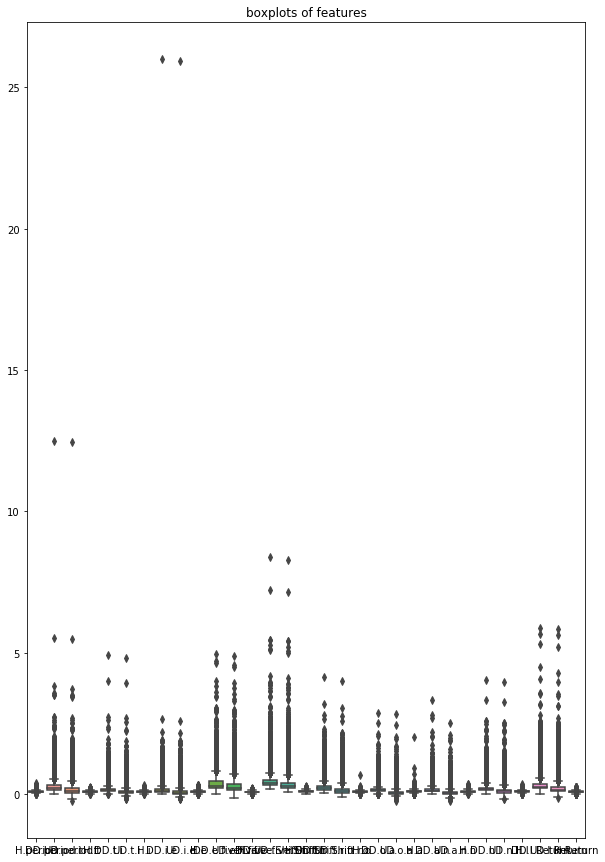

In [62]:
df_1 = df.drop(['subject', 'sessionIndex', "rep"], axis=1)
plt.figure(figsize=(10, 15))
sns.boxplot(data=df_1)
plt.title("boxplots of features")
plt.show()

In [63]:
print(df.iloc[df["DD.i.e"].idxmax()]["subject"])
print(df.iloc[df["UD.i.e"].idxmax()]["subject"])
print(df.iloc[df["DD.period.t"].idxmax()]["subject"])

s049
s049
s043


There are extreme outliers i.e. for subject 49 time between down i- down e took 25 seconds

Also data requires normalization since the scale of features are different.

Investigate the extreme outliers of each class on both training and test data using IQR.

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


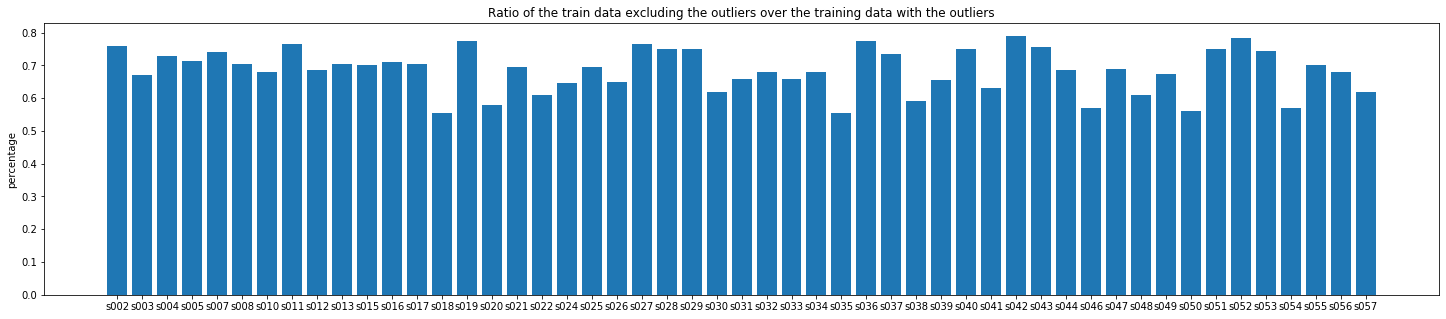

In [75]:
df_outlier_perc ={}
df_no_outliers = pd.DataFrame()
i=0
df_train = df[df['sessionIndex'] <=4]
for label in df["subject"].unique():
    df_class = df_train[df_train["subject"]==label]
    df_class = df_class.drop(['subject', 'sessionIndex', "rep"], axis=1)
    Q1 = df_class.quantile(0.25)
    Q3 = df_class.quantile(0.75)
    IQR = Q3 - Q1

    df_class_wout_outliers = df_class[~((df_class < (Q1 - 3 * IQR)) |(df_class > (Q3 + 3 * IQR))).any(axis=1)]
    df_outlier_perc[label] = len(df_class_wout_outliers)/len(df_class)
    df_class_wout_outliers["subject"] = label
    
    if i == 0:
        df_no_outliers = df_class_wout_outliers
    else:
        df_no_outliers = pd.concat([df_class_wout_outliers, df_no_outliers])
    i+=1
        
plt.figure(figsize = (25,5))
plt.title("Ratio of the train data excluding the outliers over the training data with the outliers")
plt.bar(df_outlier_perc.keys(), df_outlier_perc.values())
plt.ylabel('Ratio')
plt.xlabel('Subjects')
plt.show()

Extreme outlier ratio for each class in test data:

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


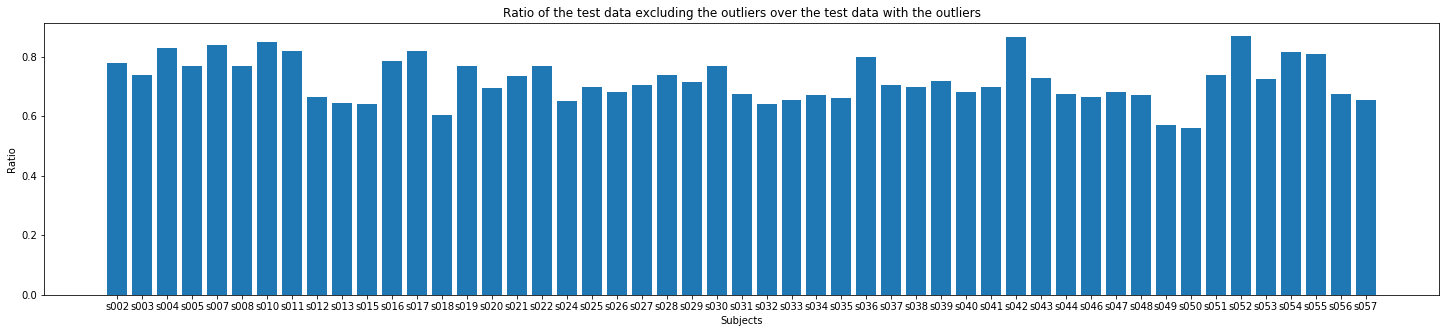

In [78]:
df_outlier_perc ={}
df_no_outliers = pd.DataFrame()
i=0
df_test = df[df['sessionIndex'] >4]
for label in df["subject"].unique():
    df_class = df_test[df_test["subject"]==label]
    df_class = df_class.drop(['subject', 'sessionIndex', "rep"], axis=1)
    Q1 = df_class.quantile(0.25)
    Q3 = df_class.quantile(0.75)
    IQR = Q3 - Q1

    df_class_wout_outliers = df_class[~((df_class < (Q1 - 3 * IQR)) |(df_class > (Q3 + 3 * IQR))).any(axis=1)]
    df_outlier_perc[label] = len(df_class_wout_outliers)/len(df_class)
    df_class_wout_outliers["subject"] = label
    
    if i == 0:
        df_no_outliers = df_class_wout_outliers
    else:
        df_no_outliers = pd.concat([df_class_wout_outliers, df_no_outliers])
    i+=1
        
plt.figure(figsize = (25,5))
plt.title("Ratio of the test data excluding the outliers over the test data with the outliers")
plt.bar(df_outlier_perc.keys(), df_outlier_perc.values())
plt.ylabel('Ratio')
plt.xlabel('Subjects')
plt.show()

Since both train and test datasets have outliers, I will keep them.

### Heatmap of features 

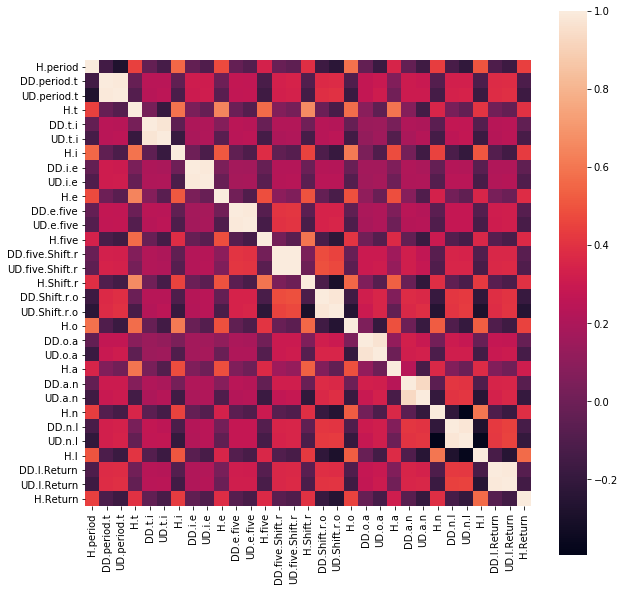

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_1.corr(),square=True)
plt.show()

- Down-down and up-down times are strongly correlated. This is expected since dd = ud + h
- Ud and dd correlations are also very similar with other features.
- They can be removed.

Heatmap without DD features

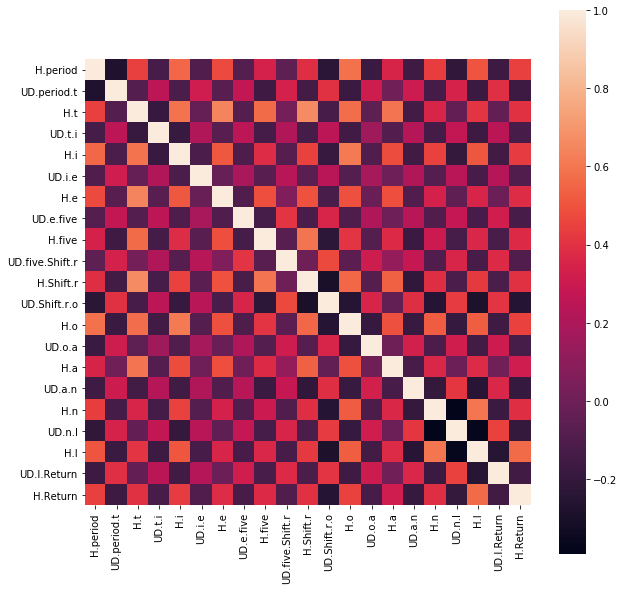

In [52]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_1.drop( list(df.columns[df.columns.str.startswith('DD')]),axis=1).corr(),square=True)
plt.show()

Feature correlations are more interpretable now.
- Hold times are more correlated between themselves
- Similarly, up-down times are more correlated between themselves

See if subjects can be distinguished by Hold and Up-down features


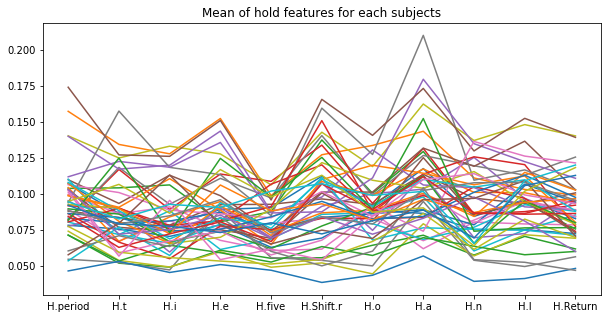

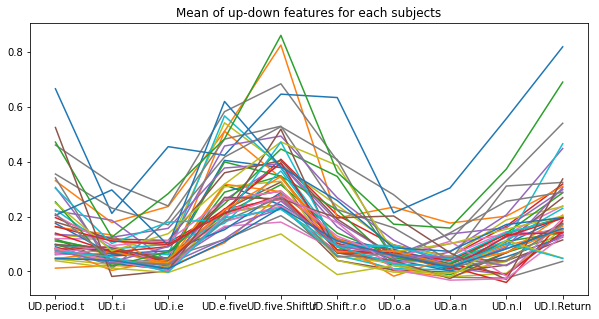

In [53]:
features_hold = list(df.columns[df.columns.str.startswith('H')])
features_hold.append("subject")

user_hold = df[features_hold]
mean_users = user_hold.groupby(['subject']).mean()
plt.figure(figsize=(10, 5))
plt.title("Mean of hold features for each subjects")
for i in range(0,51):
    plt.plot(mean_users.iloc[i])

plt.show()

features_ud = list(df.columns[df.columns.str.startswith('UD')])
features_ud.append("subject")

user_ud = df[features_ud]
mean_ud = user_ud.groupby(['subject']).mean()
plt.figure(figsize=(10, 5))
plt.title("Mean of up-down features for each subjects")

for i in range(0,51):
    plt.plot(mean_ud.iloc[i])

plt.show()

- some people's average characteristics are more similar while others more different

## Data Preprocessing

In [46]:
df_train = df[df['sessionIndex'] <=4]
df_test = df[df['sessionIndex'] > 4]

df_train = df_train.drop(list(df_train.columns[df_train.columns.str.startswith('UD')]), axis=1)
df_test = df_test.drop(list(df_test.columns[df_test.columns.str.startswith('UD')]), axis=1)

y_train = df_train["subject"]
y_test = df_test["subject"]

df_1_train = df_train.drop(['subject', 'sessionIndex', "rep"], axis=1)
df_1_test = df_test.drop(['subject', 'sessionIndex', "rep"], axis=1)

Normalize the data so that features scales will be same between 0 and 1.

In [54]:
scaler = MinMaxScaler()
scaler.fit(df_1_train)

df_train_norm = scaler.transform(df_1_train)
df_train_norm = pd.DataFrame(df_train_norm)
df_test_norm = scaler.transform(df_1_test)
df_test_norm = pd.DataFrame(df_test_norm)

df_train_norm["subject"] = df_train_norm["subject"] = y_train.to_list()
df_test_norm["subject"] = df_train_norm["subject"] = y_test.to_list()

### One vs All Classification

- Since the task is one vs all classification problem, first, check whether the distribution of features are distinguishable between subject herself and another person/fraud.

- However, converting the problem to fraud/nonfraud as binary classification problem makes the dataset imbalanced.


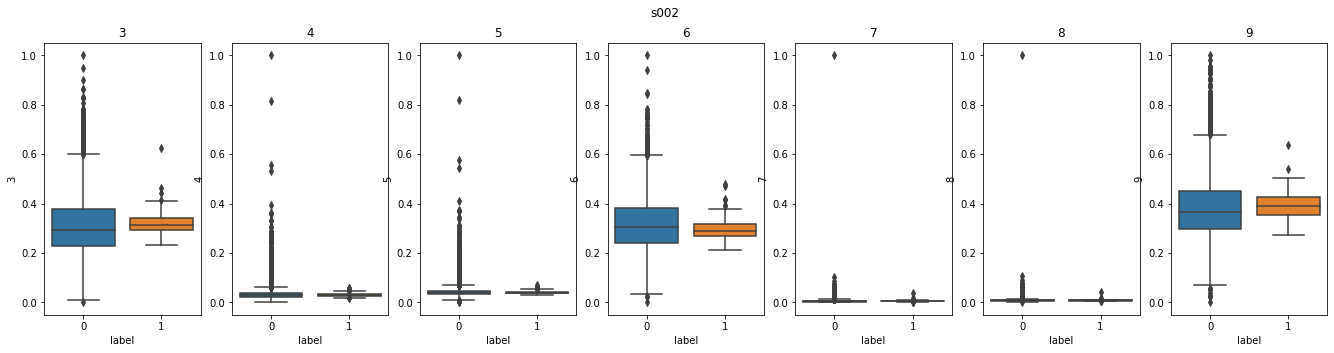

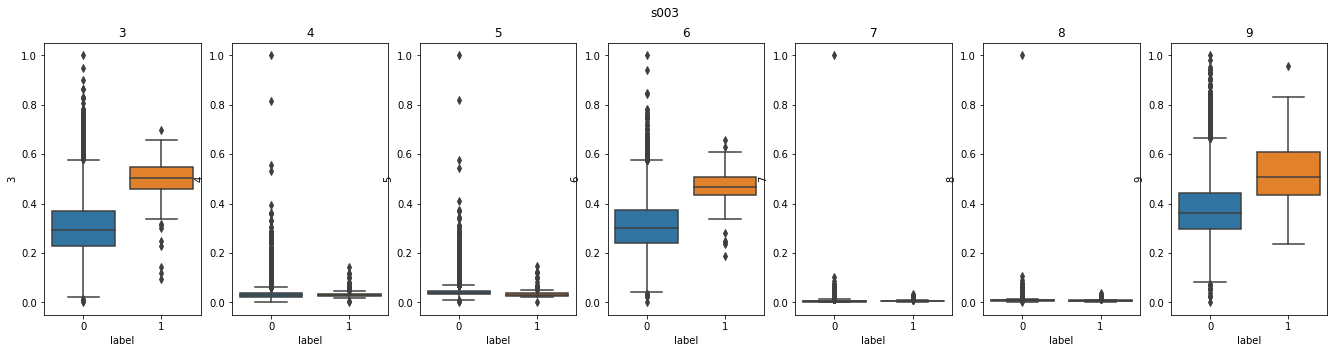

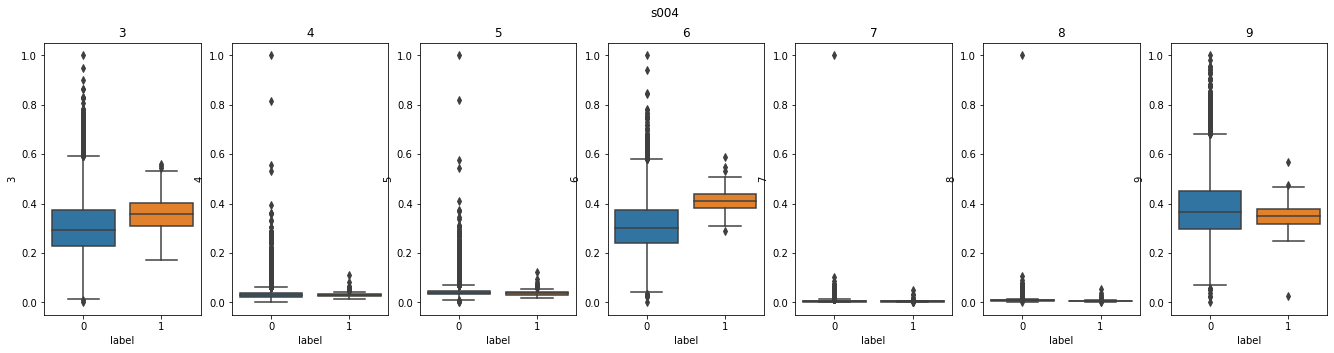

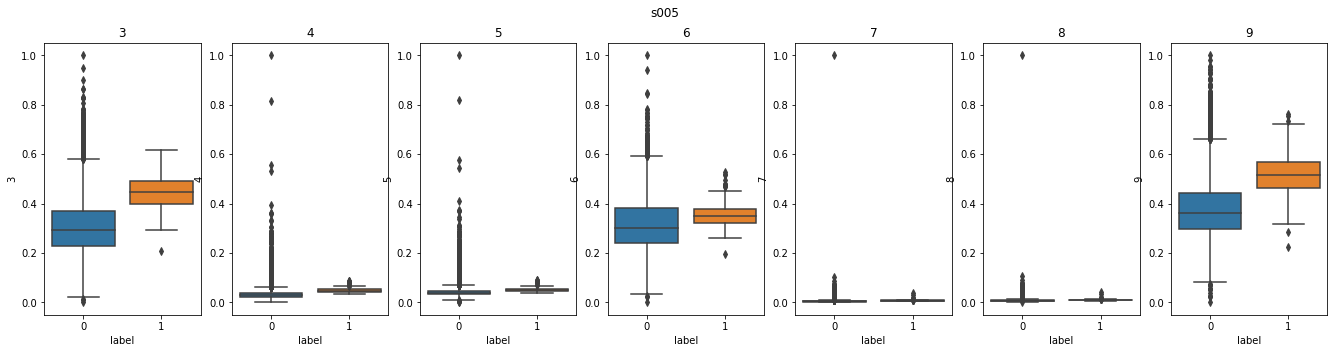

In [56]:
labels = [ "s002", "s003", "s004", "s005"]
for label in labels:
    df_subs_pos = df_train_norm[df_train_norm["subject"] == label]
    df_subs_neg = df_train_norm[df_train_norm["subject"] != label]
    new_df = pd.concat([df_subs_pos, df_subs_neg])
    new_y = np.repeat([1, 0], [200, 10000], axis=0)
    new_df["label"]=new_y
    
    fig, axs = plt.subplots(ncols=7, figsize=(23, 5))

    for i,val in enumerate(list(new_df.columns[3:10])):
        sns.boxplot(
            data=new_df,
            x='label',
            y=val,
            ax=axs[i]).set_title(val)

        plt.suptitle(label)
    plt.show()

- Some of the features distribution are clearly distinguishable between the subject and other subject distributions.
- Let's see the distances between the subject mean and some of subject's and a fraud's.

distance between mean and negative samples mean:
0.33765100970556877
distance between mean and pos samples mean:
0.08934502151682798


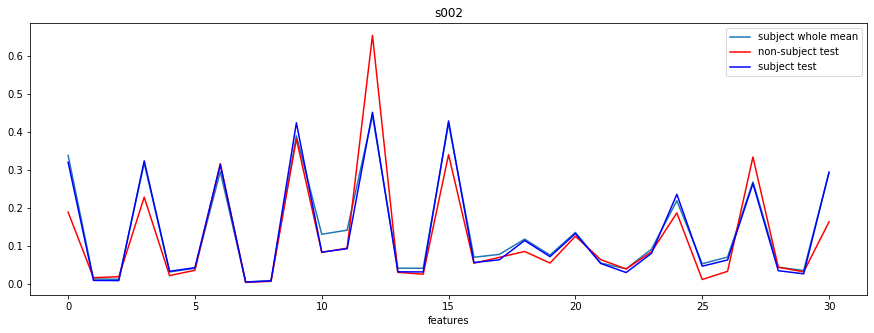

distance between mean and negative samples mean:
0.4722427501510937
distance between mean and pos samples mean:
0.25676048787826394


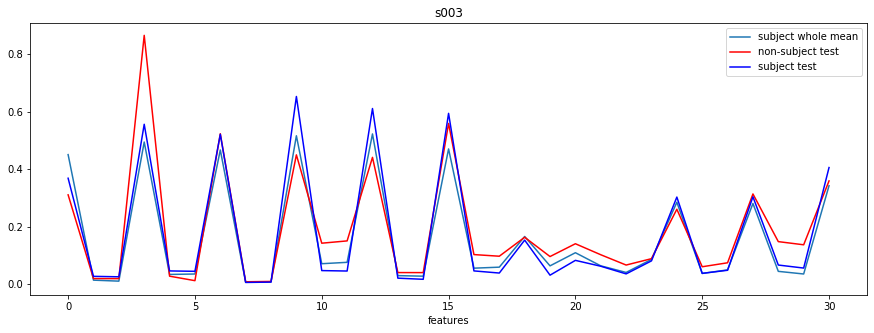

distance between mean and negative samples mean:
0.5121241096449528
distance between mean and pos samples mean:
0.09707301744789132


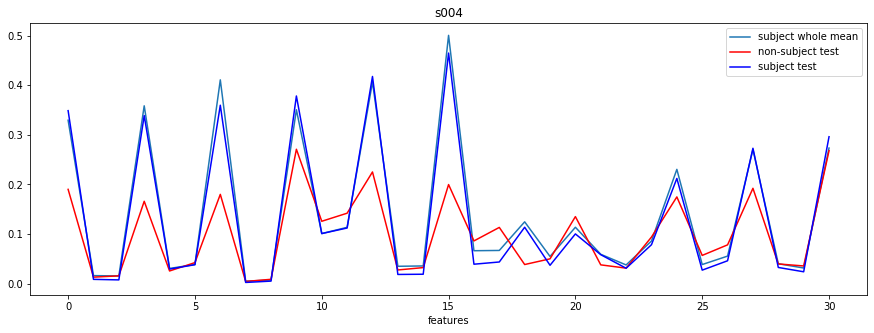

distance between mean and negative samples mean:
0.4302853083375734
distance between mean and pos samples mean:
0.15579413560234295


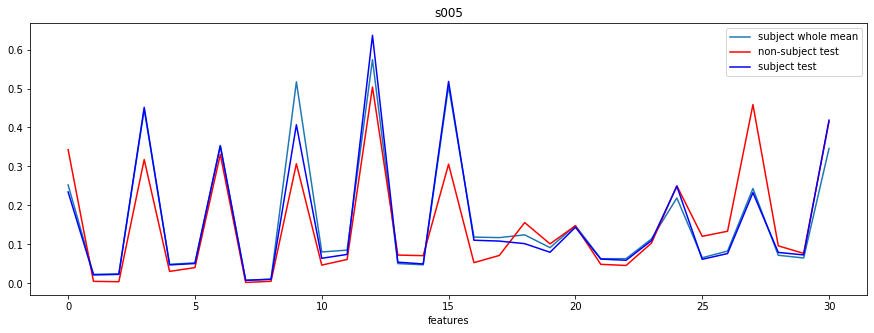

In [57]:
labels = [ "s002", "s003", "s004", "s005"]

for label in labels:
    df_pos = df_train_norm[df_train_norm["subject"] == label]
    means = np.mean(df_pos.drop(["subject"], axis =1), axis=0)

    df_pos = df_pos.drop(["subject"], axis =1)
    df_pos_sub = df_pos.sample(frac=1).head(1)
    df_pos_sub_mean = np.mean(df_pos_sub,axis=0)
    
    df_neg = df_train_norm[df_train_norm["subject"] != label]
    df_subs_neg = df_neg.sample(frac=1).head(1)
    df_subs_neg = df_subs_neg.drop(["subject"], axis =1)
    df_subs_neg = np.mean(df_subs_neg, axis= 0)

    print("distance between mean and negative samples mean:")
    print(np.sqrt(np.sum((df_subs_neg  - means  )**2)))
    print("distance between mean and pos samples mean:")
    print(np.sqrt(np.sum((df_pos_sub_mean - means  )**2)))
    plt.figure(figsize = (15,5))
    plt.plot(means, label="subject whole mean")
    plt.plot(df_subs_neg , label="non-subject test", color ="red")
    plt.plot(df_pos_sub_mean , label="subject test", color ="blue")
    plt.xlabel("features")
    
    plt.title(label)

    plt.legend()
    plt.show()

- Distances to subject mean vector could help to verify if a new password attempt belongs to the subject herself.

### Model 1: Build the mean vectors as models for each class

Compute the training samples feature means vector. This will be later used to classify a password attempt based on it's distance to mean_vector.

In [58]:
mean_list  = {}

for label in y_train.unique():
    df_subs_pos = df_train_norm[df_train_norm["subject"] == label]
    df_subs_pos = df_subs_pos.drop(["subject"], axis=1)
    mean_pos = np.mean(df_subs_pos, axis=0)
    mean_list[label] = mean_pos

Calculate the distances of test samples to each mean vector and use roc curve to find the distance threshold for equal error rate.

In [65]:
eer_mean_list = {}

for label in mean_list.keys():
    
    mean_vec = mean_list.get(label)
    df_test_pos = df_test_norm[df_test_norm["subject"] == label]
    df_test_pos = df_test_pos.drop(["subject"], axis=1)
    df_test_neg = df_test_norm[df_test_norm["subject"] != label]
    df_test_neg = df_test_neg.drop([ "subject"], axis=1)
    new_test = pd.concat([df_test_neg,df_test_pos])
    new_y = np.repeat([0,1], [ 10000, 200], axis=0) #fraud - not fraud
    dist_mean_vec  = np.sqrt(((new_test - mean_vec) ** 2).sum(axis=1)) #distance

    fpr, tpr, threshold = roc_curve(new_y, 1.0-dist_mean_vec, pos_label=1)
    
    fnr = 1 - tpr
    eer_mean = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_mean_list[label] = eer_mean

Average equal error for each class:

In [66]:
print(np.mean(list(eer_mean_list.values())))

0.18255098039215686


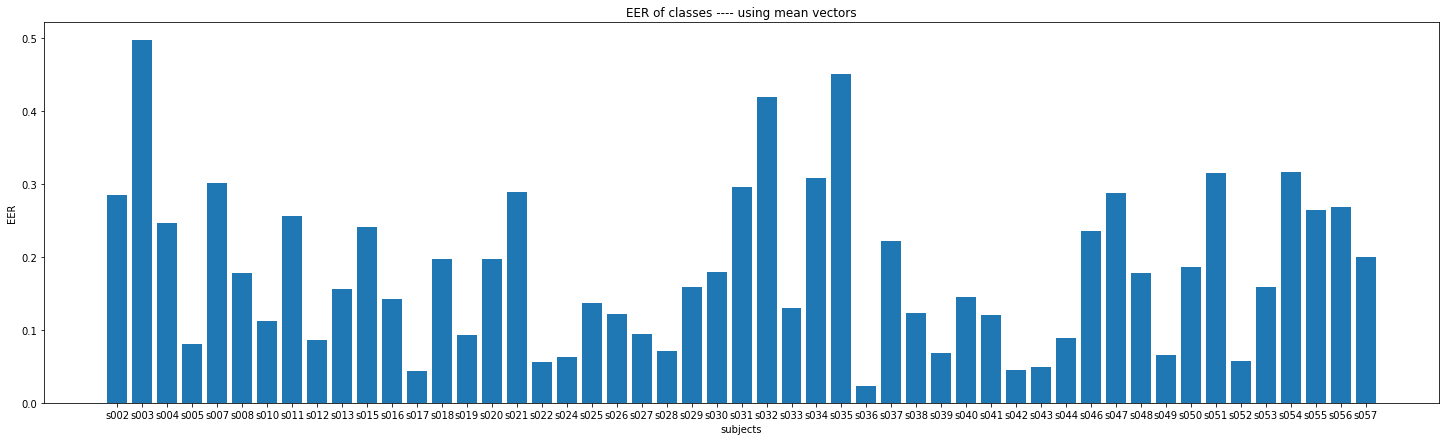

In [67]:
plt.figure(figsize = (25,7))
plt.title("EER of classes ---- using mean vectors")
plt.bar(eer_mean_list.keys(), eer_mean_list.values())
plt.xlabel('subjects')
plt.ylabel('EER')
plt.show()

Subject 3 has the highest error. 

### Model 2: k-nn
How would the nearest neighbours distances perform instead of looking for a mean vector, if the distance to the neighbour vectors would be used?
- Train k-nn models for each training subject.
- First I tried to use all the training data (10000 negative classes) , but it took long time.
- I decide to downsample the negative classes so it would be more balanced and faster.
- I will downsample 4 subjects from each class, so that both positive and negative class sizes will be same = 200.

In [68]:
model_list_k_3 = {}
model_list_k_5 = {}

for label in y_train.unique():
    df_subs_pos = df_train_norm[df_train_norm["subject"] == label]
    df_subs_pos = df_subs_pos.drop(["subject"], axis=1)

    df_subs_neg = df_train_norm[df_train_norm["subject"] != label]
    df_subs_neg = df_subs_neg.sample(frac=1).groupby('subject').head(4)
    df_subs_neg = df_subs_neg.drop(["subject"], axis=1)
    
    new_test = pd.concat([df_subs_pos, df_subs_neg])
    new_y = np.repeat([1,0], [ 200, 200], axis=0) #  fraud - not fraud
    model_list_k_3[label] =  k_nn(new_test, new_y, 3)
    model_list_k_5[label] =  k_nn(new_test, new_y, 5)

Model testing: Find the k closest training points to the new test points

In [69]:
eer_knn_list_3 ={}
eer_knn_list_5 ={}

for label in model_list_k_3.keys():
    df_test_pos = df_test_norm[df_test_norm["subject"] == label]
    df_test_neg = df_test_norm[df_test_norm["subject"] != label]
    df_test_pos = df_test_pos.drop(["subject"], axis=1)
    df_test_neg = df_test_neg.drop(["subject"], axis=1)
    new_test = pd.concat([df_test_neg, df_test_pos])
    model_3 = model_list_k_3[label]
    model_5 = model_list_k_5[label]
    
    new_y = np.repeat([0,1], [ 10000, 200], axis=0) 
    preds_knn_3 = model_3.predict(new_test)
    preds_knn_5 = model_5.predict(new_test)

    fpr, tpr, threshold = roc_curve(new_y, preds_knn_3, pos_label=1)
    fnr = 1 - tpr
    eer_knn_list_3[label] = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

    fpr, tpr, threshold = roc_curve(new_y, preds_knn_5, pos_label=1)
    fnr = 1 - tpr
    eer_knn_list_5[label] = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

print("k=3  " + str(np.mean(list(eer_knn_list_3.values()))))
print("k=5  " + str(np.mean(list(eer_knn_list_5.values()))))

k=3  0.09456666666666667
k=5  0.08718431372549021


k=5 performed better with a little bit lower test error. This should be investigated with other k values, however since my k-nn implementation is not fast, I would find the best k value by cross validation using a faster k-nn implementation. 

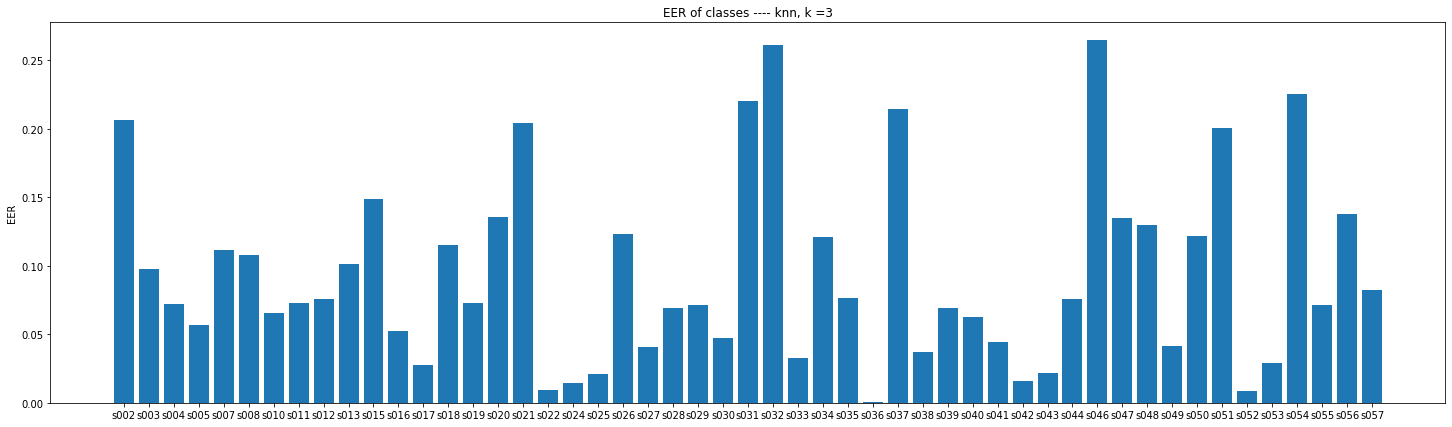

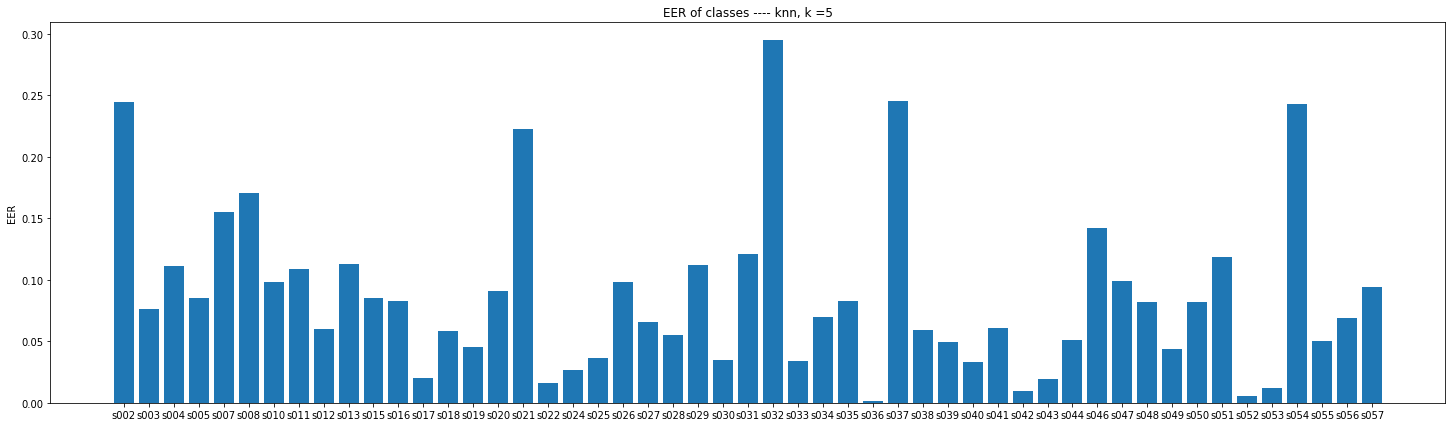

In [70]:
plt.figure(figsize = (25,7))
plt.title("EER of classes ---- knn, k =3")
plt.bar(eer_knn_list_3.keys(), eer_knn_list_3.values())
plt.ylabel('EER')
plt.show()

plt.figure(figsize = (25,7))
plt.title("EER of classes ---- knn, k =5")
plt.bar(eer_knn_list_5.keys(), eer_knn_list_5.values())
plt.ylabel('EER')
plt.show()

### Evaluation of Model Performances and Discussion

- Distance based classifiers performed well enough for a data with many outliers and many features.
- Class 3, 32 and 35 are the highest eer classes in mean-vector based approach.
- Class 32 and 46 performed worst when k= 3, while class 32, and 37 performed worst when k =5. 
- k-nn had twice lower error than mean-vector classifiers. This is expected since mean-vector based approach is more generalization, compared to finding the closest neighbours.
- Overall k-nn performed better than mean-vectors but k-nn requires storage of all training data. 

Future work:
- Investigate variance of the data with pca.
- Fit more probabilistic approaches to model distribution of subjects such as GMM to also capture the variance.